# Taking Observations

### Wave propagation 

In [ ]:
import os
import numpy as np

In [2]:
from medis.medis_main import RunMedis  # this is the top level function
from medis.plot_tools import quick2D, grid  # plotting single images or a grid of images
from medis.params import ap,tp,atmp,iop,sp,mp  # this is where all the default parameters are stored
from medis.utils import dprint  # this is just a useful function

Overwrite the parameters we care about

In [3]:
sp.save_to_disk = False  # having this off is useful initially until we start running full sims
sp.verbose = True
sp.debug = False  # this will show the results at every optic for the star at the shortest wavelength
sp.numframes = 1  # total number of time frames
sp.sample_time = 0.5e-3  # time between time frames
sp.beam_ratio = 0.1  # low value supresses the reflections in the focal plane
sp.save_list = np.array(['atmosphere','detector'])

ap.companion_xy = [[0.5,0]]  # this is 50 mas separation
ap.contrast = [1e-3]  # this is 50 mas separation
ap.companion = True
ap.n_wvl_init = 1  # single band
tp.cg_type = 'Solid'  # occulter type
tp.ao_act = 50  # number of actuators along an axis
tp.satelite_speck['apply'] = False  # object to close to care about these
tp.prescription = 'general_telescope' # 'Subaru_SCExAO'  # lets use general for now
tp.obscure = False  # spiders and M2 obscurations off for now
tp.use_ao = True
tp.use_aber = True

TESTDIR = 'demo'

First lets just intialise a simulation that generates ideal electric fields (no photon noise or dead pixels etc) for this system. This will create the top "test" directory if it does not already exist. If it does exist the params file will be checked against the requested parameters to see if they match (has not been fully verified yet)

In [4]:
sim = RunMedis(name=f'{TESTDIR}/justfields', product='fields')


	 Astro_params
{'C_spec': 1.5,
 'companion': True,
 'companion_xy': [[0.5, 0]],
 'contrast': [0.001],
 'interp_wvl': True,
 'n_wvl_final': None,
 'n_wvl_init': 1,
 'spectra': [None, None],
 'star_flux': 100000,
 'wvl_range': array([8.0e-07, 1.5e-06])}

	 Telescope_params
{'abertime': 0.5,
 'ao_act': 50,
 'cg_size': 3,
 'cg_size_units': 'l/D',
 'cg_type': 'Solid',
 'entrance_d': 5,
 'fit_dm': True,
 'fl_cg_lens': 1000,
 'flen_primary': 25,
 'fnum_primary': 12,
 'legs_frac': 0.03,
 'lens_params': None,
 'lyot_size': 0.75,
 'obscure': False,
 'piston_error': False,
 'pix_shift': [0, 0],
 'prescription': 'general_telescope',
 'satelite_speck': {'amp': 1.2e-08,
                    'apply': False,
                    'phase': 0.6283185307179586,
                    'xloc': 12,
                    'yloc': 12},
 'servo_error': [0, 1],
 'use_aber': True,
 'use_ao': True,
 'use_atmos': True,
 'zernike_orders': [2, 3, 4],
 'zernike_vals': array([ 1.75e-07, -1.50e-07,  2.00e-07])}

	 Atmos_params

Calling sim will begin the observation that generates the fields ndarray. It will create all the directories, atmosphere maps, aberration maps, coronagraph maps and check if the simulation needs to be chunked to fit into the dynamic memory or not

since params['sp'].debug is True it will produce lots of plots

In [5]:
observation = sim()

Copying over prescription /Users/dodkins/PythonProjects/MEDIS++/simulations/general_telescope/general_telescope.py

MEDIS++/medis/atmosphere.py:71 - Making New Atmosphere Model


/Users/dodkins/.conda/envs/pipeline-new/lib/python3.7/site-packages/hcipy/atmosphere/atmospheric_model.py:181: UserWarning: Please use the correct spelling for scintillation.
  warnings.warn('Please use the correct spelling for scintillation.')


MEDIS++/medis/atmosphere.py:137 - atmos file = /Users/dodkins/MKIDSim/demo/justfields2/atmos/gridsz512_bmratio0.1_tsteps1/atmos_t0.000000_single_wvl8.000e-07.fits
MEDIS++/medis/aberrations.py:50 - Generating optic aberration maps using Proper at directory /Users/dodkins/MKIDSim/demo/justfields2/aberrations/gridsz512_bmratio0.1_tsteps1
pyFFTW not found, using Numpy FT.
MEDIS++/medis/aberrations.py:50 - Generating optic aberration maps using Proper at directory /Users/dodkins/MKIDSim/demo/justfields2/aberrations/gridsz512_bmratio0.1_tsteps1
pyFFTW not found, using Numpy FT.
Each timestep is predicted to be 4.194304 MB, meaning no more than 2384.0 time steps can fit in the memory at one time
File total size should be 4.194304 MB
Using time chunks of size 1
No mode specfified defaulting to markov (time independent)


	Beginning Telescope Simulation with MEDIS


MEDIS++/medis/optics.py:211 - saving plane at atmosphere
MEDIS++/medis/optics.py:189 - Rupert--debug this for gen_telescope. You s

This demonstration shows reflections in the focal plane at wide separation which woould be reduced with an increase in grid_size and decrease in beam_ratio if neccessary.

From this dictionary we can look at the fields ndarray

dict_keys(['fields', 'sampling'])
fields being sliced by [1 1] making new fields size (1, 2, 512, 512)
fields being sliced by [1 1] making new fields size (1, 2, 512, 512)


/Users/dodkins/.conda/envs/pipeline-new/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


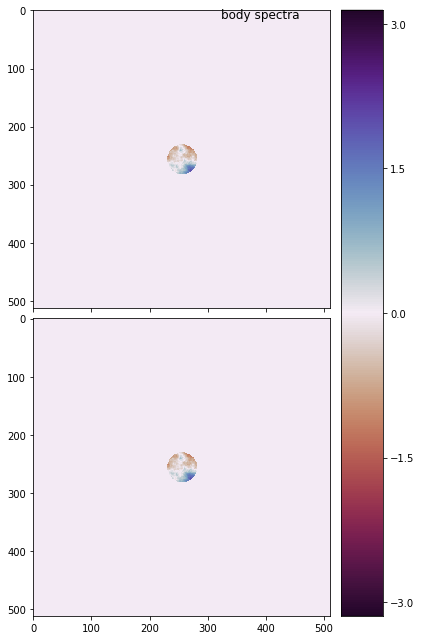

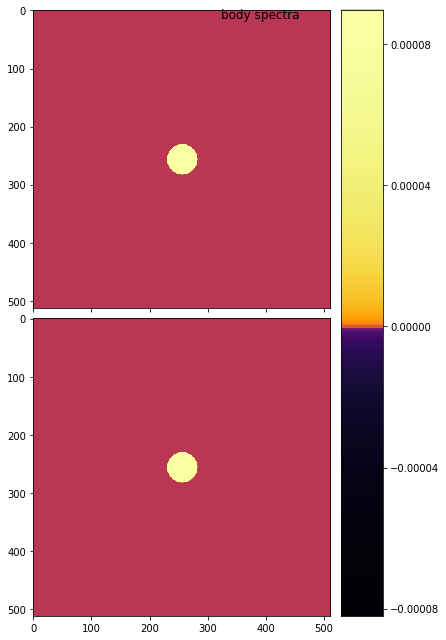

In [6]:
print(observation.keys())
fields = observation['fields']
grid(np.angle(fields[0,0]), vlim=(-np.pi, np.pi), show=False, cmap='sunlight')
grid(fields[0,0], logZ=True, nstd=2, show=True)

### Quantization

Now lets repeat the process but use the product == 'photons' option for RunMedis 

In [10]:
sp.debug = False  # we already know what the planes look like now
sp.save_to_disk = True  # save fields and save photons so they can be loaded
ap.star_flux = 1e9  # lets assume 1e9 photons across the array per second
mp.platescale = 10 *1e-3 # 10mas/pix
mp.array_size = np.array([100,100])  # this will take the center 100*10mas of the input image
sp.numframes = 20 # 20 * 0.5 ms = 10 ms of photon data
sim = RunMedis( name=f'{TESTDIR}/photonlist', product='rebinned_cube')


	 Astro_params
{'C_spec': 1.5,
 'companion': True,
 'companion_xy': [[0.5, 0]],
 'contrast': [0.001],
 'interp_wvl': True,
 'n_wvl_final': 1,
 'n_wvl_init': 1,
 'spectra': [None, None],
 'star_flux': 1000000000.0,
 'wvl_range': array([8.0e-07, 1.5e-06])}

	 Telescope_params
{'abertime': 0.5,
 'ao_act': 50,
 'cg_size': 3,
 'cg_size_units': 'l/D',
 'cg_type': 'Solid',
 'entrance_d': 5,
 'fit_dm': True,
 'fl_cg_lens': 1000,
 'flen_primary': 25,
 'fnum_primary': 12,
 'legs_frac': 0.03,
 'lens_params': [{'aber_vals': [5e-18, 2.0, 3.1],
                  'diam': 0.2,
                  'dist': 1.345,
                  'focal_length': 1.2,
                  'name': 'CPA'},
                 {'aber_vals': [5e-18, 2.0, 3.1],
                  'diam': 0.2,
                  'dist': 1.345,
                  'focal_length': 1.2,
                  'name': 'NCPA'}],
 'lyot_size': 0.75,
 'obscure': False,
 'piston_error': False,
 'pix_shift': [0, 0],
 'prescription': 'general_telescope',
 'satelite_sp

This will create a new folder with a new fields ndarray (this time with more timesteps) and generate photons from it

In [13]:
observation = sim()
print(observation.keys(), observation['rebinned_cube'].shape)

Using prescription /Users/dodkins/PythonProjects/MEDIS++/simulations/general_telescope/general_telescope.py

Atmosphere maps already exist at 
	/Users/dodkins/MKIDSim/demo/photonlist/atmos/gridsz512_bmratio0.1_tsteps20 
... skipping generation


Aberration maps already exist at 
	/Users/dodkins/MKIDSim/demo/photonlist/aberrations/gridsz512_bmratio0.1_tsteps20 
... skipping generation


Each timestep is predicted to be 4.194304 MB, meaning no more than 2384.0 time steps can fit in the memory at one time
File total size should be 83.88607999999999 MB
Using time chunks of size 20
No mode specfified defaulting to markov (time independent)
Loading fields from /Users/dodkins/MKIDSim/demo/photonlist/fields.h5
Shape of cpx_sequence = timesteps:20, save planes:2, wavelengths:1, astronomical bodies:2, x:512, y:512
This observation will produce 85768 photons, which is 0.002744576 GB, meaning no more than 3643.5500419736964 of this observation can fit in the memory at one time
Input cubes will be 

The simulation produced 100000 photons with 20 time samples, 1 wavelength sample on a 100 by 100 array

observation['stackcube'] is already in nice format for viewing. Lets plot every 5th timestep

fields being sliced by [4 1] making new fields size (5, 1, 100, 100)


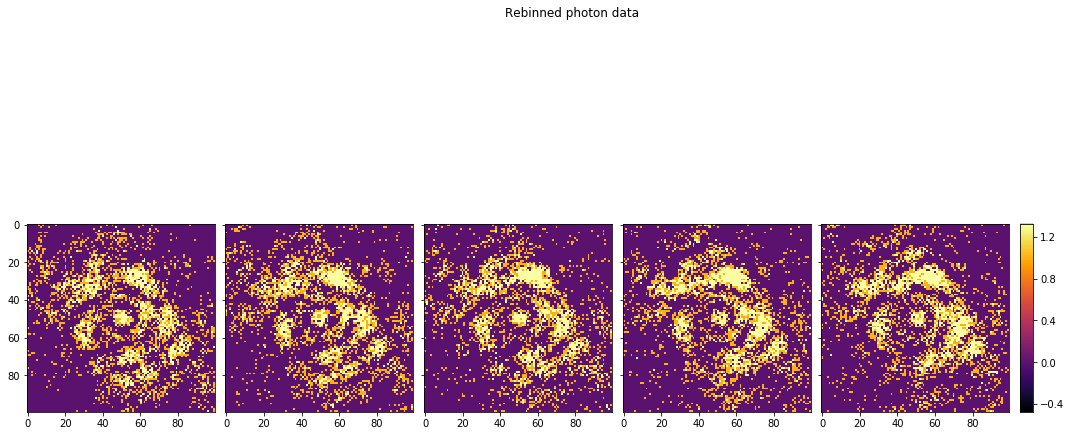

In [15]:
grid(observation['rebinned_cube'], show=True, title='Rebinned photon data')